In [66]:
from aemeasure import read_as_pd
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()


In [67]:
from pcpptc import PolygonInstance, Solution
from pcpptc.plot import setup_plot, plot_polygon_instance, plot_solution
from pcpptc.plot.polgyon_instance import plot_coverage

In [68]:
read_as_pd("./solutions/2.results.json").columns

Loaded dataframe ./solutions/2.results.json
Executed on: ['algry01' 'algry03']
During: 2021-08-19 14:08:26.172107 and 2021-08-19 21:08:53.475409


Index(['solution', 'coverage', 'touring_cost', 'length', 'turn_sum',
       'instance', 'instance_path', 'runtime', 'timestamp', 'hostname', 'argv',
       'git_revision', 'cwd', 'solver', 'i', 'turn_factor'],
      dtype='object')

In [69]:
tables = []
for f in os.listdir("./solutions"):
    if not f.endswith(".results.json"):
        continue
    f = os.path.join("./solutions", f)
    tables.append(read_as_pd(f))

data = pd.concat(tables, ignore_index=True)
data.dropna(inplace=True)
data.drop_duplicates(["solver", "instance"], inplace=True)

Loaded dataframe ./solutions/75.results.json
Executed on: ['algry01']
During: 2021-08-19 13:45:51.855705 and 2021-08-19 23:23:13.332391
Loaded dataframe ./solutions/156.results.json
Executed on: ['algry03']
During: 2021-08-19 20:17:54.467402 and 2021-08-19 21:06:58.078076
Loaded dataframe ./solutions/119.results.json
Executed on: ['algry03']
During: 2021-08-19 16:58:32.963196 and 2021-08-19 17:16:04.019680
Loaded dataframe ./solutions/173.results.json
Executed on: ['algry01']
During: 2021-08-19 17:06:12.642626 and 2021-08-19 17:21:29.947470
Loaded dataframe ./solutions/144.results.json
Executed on: ['algry01']
During: 2021-08-19 16:56:09.590524 and 2021-08-19 17:08:05.162376
Loaded dataframe ./solutions/185.results.json
Executed on: ['algry01' 'algry03']
During: 2021-08-19 19:08:39.438329 and 2021-08-19 20:50:40.512053
Loaded dataframe ./solutions/154.results.json
Executed on: ['algry03' 'algry01']
During: 2021-08-19 20:26:45.769972 and 2021-08-19 21:16:31.201102
Loaded dataframe ./sol

In [70]:
from pcpptc.instance_converter.dmsh import GmshGrid


def rename(s):
    names = {
        "DmshAlgorithm(DmshGrid(full_coverage=True, point_based=False, opt=CVT-full, scale=0.95, buffer=0.05, simplification=0.1, iterations=1000, hard_corners=True))": "\u25B3dmsh(95%)",
        "DmshAlgorithm(DmshGrid(full_coverage=True, point_based=False, opt=CVT-full, scale=0.9, buffer=0.05, simplification=0.1, iterations=1000, hard_corners=True))": "\u25B3dmsh(90%)",
        "DmshAlgorithm(DmshGrid(full_coverage=True, point_based=False, opt=CVT-full, scale=1.0, buffer=0.05, simplification=0.1, iterations=1000, hard_corners=True))": "\u25B3dmsh",
        "GmshAlgorithm(GmshGrid(full_coverage=True, point_based=False, quad=False, alg=1, opt=CVT-full, scale=1.0, buffer=0.05, simplification=0.1, iterations=1000, hard_corners=True, hole_workaroundTrue))": f"\u25B3MA",
        "GmshAlgorithm(GmshGrid(full_coverage=True, point_based=False, quad=False, alg=6, opt=CVT-full, scale=1.0, buffer=0.05, simplification=0.1, iterations=1000, hard_corners=True, hole_workaroundTrue))": f"\u25B3FD",
        "GmshAlgorithm(GmshGrid(full_coverage=True, point_based=False, quad=False, alg=8, opt=CVT-full, scale=1.0, buffer=0.05, simplification=0.1, iterations=1000, hard_corners=True, hole_workaroundTrue))": f"\u25B3FDQ",
        "GmshAlgorithm(GmshGrid(full_coverage=True, point_based=False, quad=False, alg=9, opt=CVT-full, scale=0.95, buffer=0.05, simplification=0.1, iterations=1000, hard_corners=True, hole_workaroundTrue))": f"\u25B3PP(95%)",
        "GmshAlgorithm(GmshGrid(full_coverage=True, point_based=False, quad=False, alg=9, opt=CVT-full, scale=0.9, buffer=0.05, simplification=0.1, iterations=1000, hard_corners=True, hole_workaroundTrue))": f"\u25B3PP(90%)",
        "GmshAlgorithm(GmshGrid(full_coverage=True, point_based=False, quad=False, alg=9, opt=CVT-full, scale=1.0, buffer=0.05, simplification=0.1, iterations=1000, hard_corners=True, hole_workaroundTrue))": f"\u25B3PP",
        "GmshAlgorithm(GmshGrid(full_coverage=True, point_based=False, quad=True, alg=8, opt=CVT-full, scale=1.0, buffer=0.05, simplification=0.1, iterations=1000, hard_corners=True, hole_workaroundTrue))": "\u25A1FDQ",
        "GmshAlgorithm(GmshGrid(full_coverage=True, point_based=False, quad=True, alg=9, opt=CVT-full, scale=1.0, buffer=0.05, simplification=0.1, iterations=1000, hard_corners=True, hole_workaroundTrue))": f"\u25A1PP",
    }
    return names.get(s, s)


data["solver"] = data["solver"].apply(rename)

In [71]:
data["type"] = data["solver"].apply(lambda s: "hex" if "Hex" in s else "square")
data["point_based"] = data["solver"].apply(lambda s: "pb=True" in s)

In [72]:
instance_paths = list(data["instance_path"].unique())
instances = [PolygonInstance.from_json(file_path=f) for f in instance_paths]
instance_areas = pd.DataFrame(
    data={"area": [i.original_area.area for i in instances]}, index=instance_paths
)
data = data.merge(instance_areas, left_on="instance_path", right_index=True)

In [73]:
data["relative_coverage"] = data["coverage"] / data["area"]

In [74]:
data = data[data["relative_coverage"] >= 0.95]

In [75]:
t_ = data.groupby("instance")[["touring_cost"]].min()
data = data.merge(t_, left_on="instance", right_index=True, suffixes=("", "_min"))
data["relative_cost"] = data["touring_cost"] / data["touring_cost_min"]

In [76]:
instances = data["instance"].unique()
instance_data = data[data["instance"] == instances[1]]

../01_grid/instances/156.instance.json
Turn Cost: 5.0


<Figure size 432x288 with 0 Axes>

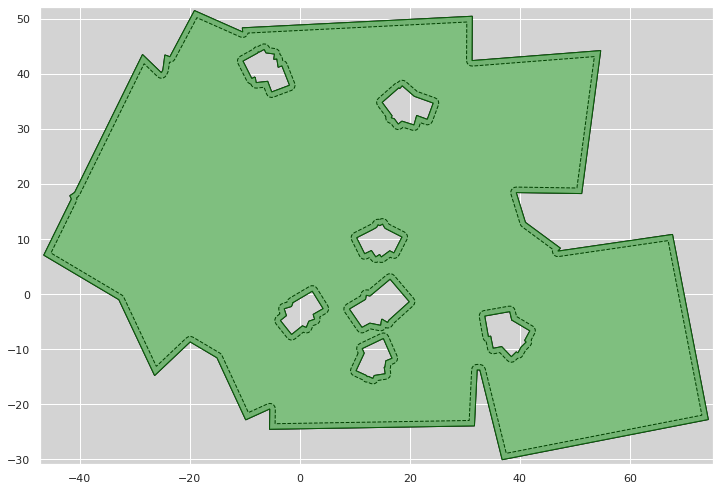

In [77]:
instance_path = instance_data.iloc[0]["instance_path"]
print(instance_path)
instance = PolygonInstance.from_json(file_path=instance_path)
print("Turn Cost:", instance.turn_cost)

ax = setup_plot(figsize=(10, 10))
plot_polygon_instance(ax, instance)
plt.show()

In [78]:
def plot(row, path=None, ax=None):
    instance_path = row["instance_path"]
    instance = PolygonInstance.from_json(file_path=instance_path)
    solution = Solution.from_json(data=row["solution"])
    if not ax:
        ax = setup_plot(figsize=(4.5, 4.5))
    plot_polygon_instance(ax, instance, set_limits=True)
    plot_solution(ax, solution)
    plot_coverage(ax, instance, solution)
    # plt.title(f"Solver: {row['solver']}, Cost: {round(row['touring_cost'],2)}, Coverage: {round(100*row['relative_coverage'],1)}%")
    if path:
        plt.tight_layout()
        plt.savefig(path)
    # plt.show()

In [79]:
from collections import defaultdict

best_instances = defaultdict(list)
t = data[(data["relative_cost"] <= 1.05) & (data["relative_coverage"] >= 0.95)]
for solver in t["solver"].unique():
    for i, row in t[t["solver"] == solver].head(10).iterrows():
        best_instances[row["solver"]].append(row)
        print(row["solver"])
        print("Cost:", row["relative_cost"])
        print("Coverage:", row["relative_coverage"])
        # plot(row, None)

△FDQ
Cost: 1.0
Coverage: 0.9575256141434305
△FDQ
Cost: 1.0
Coverage: 0.9592611447899585
△FDQ
Cost: 1.008903035860006
Coverage: 0.9522943647205827
△FDQ
Cost: 1.0
Coverage: 0.9680606022594447
△FDQ
Cost: 1.0185414149296164
Coverage: 0.9659270923102503
△FDQ
Cost: 1.0
Coverage: 0.9579247669557126
△FDQ
Cost: 1.0433663753096953
Coverage: 0.9736807859227824
△FDQ
Cost: 1.033324589187108
Coverage: 0.9815447517868687
△FDQ
Cost: 1.0
Coverage: 0.9559777430224492
△FDQ
Cost: 1.0
Coverage: 0.9638839031076439
△dmsh
Cost: 1.0
Coverage: 0.9502209078295039
△dmsh
Cost: 1.0
Coverage: 0.9550145935525445
△dmsh
Cost: 1.0
Coverage: 0.9666539340593088
△dmsh
Cost: 1.0142003679902585
Coverage: 0.9528963381474574
△dmsh
Cost: 1.0
Coverage: 0.9594881505411577
△dmsh
Cost: 1.0
Coverage: 0.954245612650473
△dmsh
Cost: 1.0
Coverage: 0.962079054718518
△dmsh
Cost: 1.0
Coverage: 0.9652016137881594
△dmsh
Cost: 1.0
Coverage: 0.9663187903450577
△dmsh
Cost: 1.0
Coverage: 0.951020371234167
△dmsh(90%)
Cost: 1.0476977786957369
Cove

In [80]:
t.groupby(["solver"])["instance"].nunique()

solver
□PP             8
△FD             9
△FDQ           56
△MA            18
△PP            46
△PP(90%)       16
△PP(95%)       71
△dmsh          60
△dmsh(90%)     21
△dmsh(95%)    133
Name: instance, dtype: int64

In [81]:
import random


def create_sample(solver, path=None):
    # fig, axes = plt.subplots(1,5,figsize=(10,2), sharex=True, sharey=True)
    fig, axes = plt.subplots(1, 5, figsize=(10, 2))
    plt.tight_layout()
    instances = random.sample(best_instances[solver], 5)
    for i in range(0, 5):
        if i >= len(best_instances[solver]):
            break
        # ax = axes[i//5, i%5]
        print(instances[i]["instance"])
        ax = axes[i]
        ax.set_aspect("equal", adjustable="box")
        # plot_polygon_instance(ax, instances[i],set_limits=False)
        plot(instances[i], ax=ax)
        ax.axis("off")
    plt.autoscale()
    plt.subplots_adjust(
        left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=-0.2, hspace=-0.2
    )
    plt.tight_layout()
    if path:
        plt.savefig(path)

52
Computing coverage polygon
Plotting coverage polygon
156
Computing coverage polygon
Plotting coverage polygon
79
Computing coverage polygon
Plotting coverage polygon
21
Computing coverage polygon
Plotting coverage polygon
119
Computing coverage polygon
Plotting coverage polygon


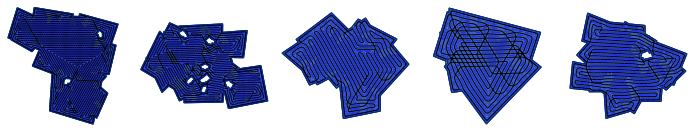

In [82]:
create_sample("△dmsh", path="./11_dmsh.pdf")
plt.show()

76
Computing coverage polygon
Plotting coverage polygon
57
Computing coverage polygon
Plotting coverage polygon
70
Computing coverage polygon
Plotting coverage polygon
161
Computing coverage polygon
Plotting coverage polygon
58
Computing coverage polygon
Plotting coverage polygon


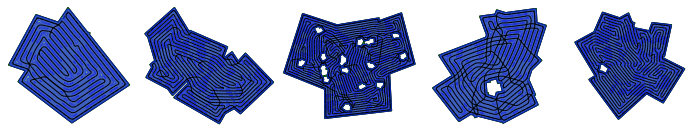

In [83]:
create_sample("△PP", path="./11_pp.pdf")
plt.show()

173
Computing coverage polygon
Plotting coverage polygon
12
Computing coverage polygon
Plotting coverage polygon
75
Computing coverage polygon
Plotting coverage polygon
35
Computing coverage polygon
Plotting coverage polygon
154
Computing coverage polygon
Plotting coverage polygon


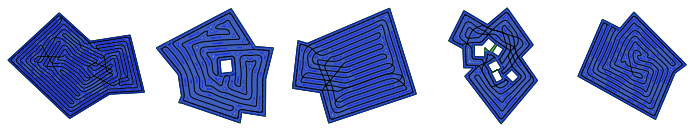

In [84]:
create_sample("△FDQ", path="./11_fdq.pdf")
plt.show()

47
Computing coverage polygon
Plotting coverage polygon
15
Computing coverage polygon
Plotting coverage polygon
9
Computing coverage polygon
Plotting coverage polygon
130
Computing coverage polygon
Plotting coverage polygon
176
Computing coverage polygon
Plotting coverage polygon


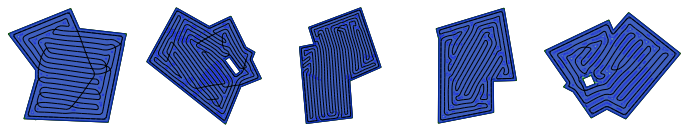

In [85]:
create_sample("△FD", path="./11_fd.pdf")
plt.show()

7
Computing coverage polygon
Plotting coverage polygon
118
Computing coverage polygon
Plotting coverage polygon
125
Computing coverage polygon
Plotting coverage polygon
1
Computing coverage polygon
Plotting coverage polygon
186
Computing coverage polygon
Plotting coverage polygon


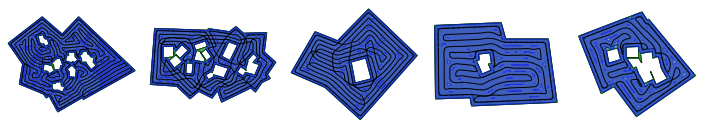

In [86]:
create_sample("△MA", path="./11_ma.pdf")
plt.show()

28
Computing coverage polygon
Plotting coverage polygon
182
Computing coverage polygon
Plotting coverage polygon
92
Computing coverage polygon
Plotting coverage polygon
173
Computing coverage polygon
Plotting coverage polygon
197
Computing coverage polygon
Plotting coverage polygon


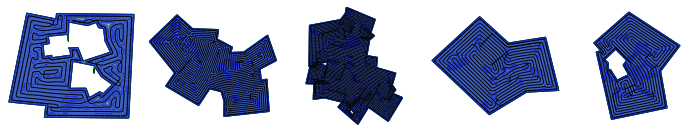

In [87]:
create_sample("□PP", path="./11_pp_square.pdf")